# Full project

## This project includes the entire process for a data science project.

#### ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../../_Datasets/aac_shelter_outcomes.csv')
df2 = df.copy()
df.head(3)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male


In [3]:
# Nulls aren't too bad, except for name and outcome_subtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


# Feature ideas

### After a quick look, we already see some features in need of 'fixing'

1. drop monthyear, it is the same as 'datetime'
    - We don't need identical features.
2. Adopted or not
    - Create binaries from this
3. name or no name
    - This might be useful
4. animal types dummies
    - We can run get_dummies on types of animals
5. Spayed/neutered vs others
    - Potential adopting parents are likely to weigh fixed animals
6. convert age to common measurement
    - Ages value are all over the place
7. fill in age_upon_outcome
    - There are some NaN values here, and it is also wild
8. simplify colors with regex, etc.
    - Colors might have correlation with adoption rates, we can find a way to include this

In [4]:
# 1. Equivalent columns.
# This code confirms these two columns are identical.
(df.datetime == df.monthyear).value_counts()

True    78256
dtype: int64

In [5]:
# Remove monthyear and rename
df.drop('monthyear', 1, inplace=True)
df.rename(columns={'datetime' : 'exit_datetime'}, inplace=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [6]:
# We want to create a binary outcome for y.
df.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [7]:
# Creating the variable with adoption versus the rest.
df['binary_outcome_adopted'] = (df.outcome_type == 'Adoption') * 1
df.drop('outcome_type', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Intact Male,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Spayed Female,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Neutered Male,1


In [8]:
# We may be able to use animal type in our model.
df.animal_type.value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [9]:
# Using dummies for dog, cat, and placing the rest in the other bin.
df['animal_dog'] = (df.animal_type == 'Dog') * 1
df['animal_cat'] = (df.animal_type == 'Cat') * 1
df['animal_other'] = ((df.animal_type == 'Other') | (df.animal_type == 'Bird') | (df.animal_type == 'Livestock')) * 1
df.drop('animal_type', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,animal_dog,animal_cat,animal_other
0,2 weeks,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Intact Male,0,0,1,0
1,1 year,A666430,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Spayed Female,0,1,0,0
2,1 year,A675708,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Neutered Male,1,1,0,0


In [10]:
# age_upon_outcome is looking pretty ugly, how inconsistent is this feature?
# If we check birthday against departure, are the numbers good?
for val in np.random.randint(0, len(df), 8):
    print(df.age_upon_outcome.loc[val])
    print(pd.to_datetime(df.exit_datetime.loc[val]) - pd.to_datetime(df.date_of_birth.loc[val]), '\n')

2 months
80 days 17:43:00 

2 years
734 days 15:10:00 

8 years
3007 days 13:51:00 

2 years
736 days 11:13:00 

1 year
471 days 13:04:00 

1 year
367 days 09:00:00 

6 years
2264 days 12:45:00 

1 year
371 days 13:49:00 



In [11]:
# df.info() above also states it has NaN values.
df[df.age_upon_outcome.isna()]

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,animal_dog,animal_cat,animal_other
68246,NaN,A737705,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,0,1,0,0
76825,NaN,A764319,Pit Bull Mix,Black/White,2016-12-27T00:00:00,2017-12-30T16:47:00,*Emma,NaN,Intact Female,0,1,0,0
77976,NaN,A765547,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,NaN,Partner,Intact Female,0,0,0,1
78081,NaN,A765899,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,NaN,Suffering,Neutered Male,0,1,0,0
78114,NaN,A765914,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,NaN,Suffering,Intact Male,0,0,1,0
78162,NaN,A765901,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,NaN,Partner,Intact Male,0,1,0,0
78208,NaN,A765960,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,NaN,Suffering,Intact Male,0,1,0,0
78253,NaN,A766098,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,NaN,Rabies Risk,Unknown,0,0,0,1


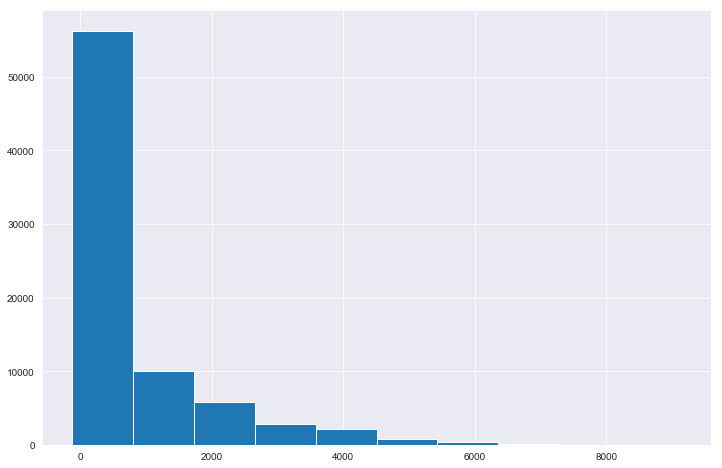

In [12]:
# This trick seems to make a usable datetime (timedelta) object.
(pd.to_datetime(df.exit_datetime) - pd.to_datetime(df.date_of_birth)).dt.days.hist(figsize=(12, 8))

In [13]:
# This converts relevant datetime entries into datetime format and creates a timedelta for age_upon_outcome
df['age_upon_outcome'] = pd.to_datetime(df.exit_datetime) - pd.to_datetime(df.date_of_birth)
df['date_of_birth'] = pd.to_datetime(df.date_of_birth)
df['exit_datetime'] = pd.to_datetime(df.exit_datetime)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,animal_dog,animal_cat,animal_other
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Intact Male,0,0,1,0
1,366 days 11:47:00,A666430,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Spayed Female,0,1,0,0
2,429 days 14:20:00,A675708,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Neutered Male,1,1,0,0


In [14]:
# Binary given_name feature
df.name.notna().value_counts()

True     54370
False    23886
Name: name, dtype: int64

In [15]:
# Name feature looks useful. Created below.
df['has_name_binary'] = df.name.notna() * 1
df.drop('name', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,animal_dog,animal_cat,animal_other,has_name_binary
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Partner,Intact Male,0,0,1,0,0
1,366 days 11:47:00,A666430,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Partner,Spayed Female,0,1,0,0,1
2,429 days 14:20:00,A675708,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,NaN,Neutered Male,1,1,0,0,1


In [16]:
# Spayed or neutered feature
df.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

In [17]:
# Creating features for fixed, male, and female animals
# Only equal values for the male/female column is at |unknown|
fixed = df.sex_upon_outcome.str.contains(r'\bNeutered\b|\bSpayed\b', regex=True)
male = df.sex_upon_outcome.str.contains(r'\bMale\b', regex=True)
female = df.sex_upon_outcome.str.contains(r'\bFemale\b', regex=True)

df[female == male]['sex_upon_outcome'].value_counts()

Unknown    6575
Name: sex_upon_outcome, dtype: int64

In [18]:
df['gender_binary'] = female * 1
df['fixed_binary'] = fixed * 1
df.drop('sex_upon_outcome', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,animal_dog,animal_cat,animal_other,has_name_binary,gender_binary,fixed_binary
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Partner,0,0,1,0,0,0,0
1,366 days 11:47:00,A666430,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Partner,0,1,0,0,1,1,1
2,429 days 14:20:00,A675708,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,NaN,1,1,0,0,1,0,1


In [19]:
# Colors?
len(df.color.value_counts())

525

In [20]:
# This will give us an idea of how much orange, black, brown, and other common colors account for the animals' colors.
display(df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b', 
                      regex=True, case=False).value_counts())

df[df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b', 
                      regex=True, case=False) == False]['color'].value_counts()[:15]

True     68839
False     9417
Name: color, dtype: int64

Tricolor       1982
Tortie         1340
Torbie          845
Yellow          510
Cream Tabby     498
Gray            489
Sable           476
Lynx Point      439
Cream           436
Chocolate       413
Buff            386
Seal Point      324
Flame Point     200
Fawn            179
Gray Tabby      132
Name: color, dtype: int64

In [21]:
# We can add a few more to the list - tricolor, gray, yellow, and the tartie/tarbie - and see how much more is covered.
df[df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b|\btricolor\b|\bgray\b|\byellow\b|\btabby\b|\btortie\b|\btorbie\b',
                         regex=True, case=False) == False]['color'].value_counts()[:15]

Sable              476
Lynx Point         439
Cream              436
Chocolate          413
Buff               386
Seal Point         324
Flame Point        200
Fawn               179
Gold               119
Lilac Point         79
Apricot             55
Chocolate Point     51
Silver              37
Pink                30
Green               20
Name: color, dtype: int64

In [22]:
# That color list looks solid - the regex tricks will allow us to convert things like Brown/Red into brown 1 and red 1
# making sure we account for common colors even if there are multiple.
color_list = ['orange', 'black', 'blue', 'brown', 'white', 'tan', 'calico', 'red', 'tricolor', 'gray', 'yellow', 'tabby', 'tortie', 'torbie']
for color in color_list:
    df['color_' + str(color)] = df.color.str.contains(r'\b' + color, case=False) * 1
    
df['color_tortie_torbie'] = df.color_torbie * 1 + df.color_tortie * 1
df.drop(['color', 'color_tortie', 'color_torbie'], 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,animal_dog,animal_cat,animal_other,...,color_brown,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,2014-07-07,2014-07-22 16:04:00,Partner,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,366 days 11:47:00,A666430,Beagle Mix,2012-11-06,2013-11-07 11:47:00,Partner,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
2,429 days 14:20:00,A675708,Pit Bull,2013-03-31,2014-06-03 14:20:00,NaN,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# What are some trends in breed?
df.breed.value_counts()

Domestic Shorthair Mix                            23335
Pit Bull Mix                                       6135
Chihuahua Shorthair Mix                            4733
Labrador Retriever Mix                             4608
Domestic Medium Hair Mix                           2323
German Shepherd Mix                                1892
Bat Mix                                            1286
Domestic Longhair Mix                              1228
Australian Cattle Dog Mix                          1059
Siamese Mix                                         998
Bat                                                 799
Dachshund Mix                                       798
Boxer Mix                                           674
Miniature Poodle Mix                                648
Border Collie Mix                                   646
Catahoula Mix                                       476
Raccoon Mix                                         465
Rat Terrier Mix                                 

In [24]:
# 'Mix' looks very common. Let's build a binary on that.
df.breed.str.contains(r'\bmix\b', case=False).value_counts()

True     65874
False    12382
Name: breed, dtype: int64

In [25]:
# mixed_binary creation and 'breed' column drop. 
# We also have some others we don't plan to use - animal_id and outcome_subtype.
df['mixed_binary'] = df.breed.str.contains(r'\bmix\b', case=False) * 1
df.drop(['breed', 'animal_id', 'outcome_subtype'], 1, inplace=True)
df.head(3)

,age_upon_outcome,date_of_birth,exit_datetime,binary_outcome_adopted,animal_dog,animal_cat,animal_other,has_name_binary,gender_binary,fixed_binary,...,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie,mixed_binary
0,15 days 16:04:00,2014-07-07,2014-07-22 16:04:00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,366 days 11:47:00,2012-11-06,2013-11-07 11:47:00,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
2,429 days 14:20:00,2013-03-31,2014-06-03 14:20:00,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [26]:
# Run a check on the summary.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 24 columns):
age_upon_outcome          78256 non-null timedelta64[ns]
date_of_birth             78256 non-null datetime64[ns]
exit_datetime             78256 non-null datetime64[ns]
binary_outcome_adopted    78256 non-null int32
animal_dog                78256 non-null int32
animal_cat                78256 non-null int32
animal_other              78256 non-null int32
has_name_binary           78256 non-null int32
gender_binary             78254 non-null object
fixed_binary              78254 non-null object
color_orange              78256 non-null int32
color_black               78256 non-null int32
color_blue                78256 non-null int32
color_brown               78256 non-null int32
color_white               78256 non-null int32
color_tan                 78256 non-null int32
color_calico              78256 non-null int32
color_red                 78256 non-null int32
color_tricolor 

In [27]:
# gender_binary and fixed_binary both have a pair of missing values.
display(df[df.fixed_binary.isna()])
df = df.dropna()

,age_upon_outcome,date_of_birth,exit_datetime,binary_outcome_adopted,animal_dog,animal_cat,animal_other,has_name_binary,gender_binary,fixed_binary,...,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie,mixed_binary
16300,2567 days 16:11:00,2006-11-17,2013-11-27 16:11:00,0,1,0,0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
68246,1113 days 16:35:00,2013-11-02,2016-11-19 16:35:00,0,1,0,0,1,NaN,NaN,...,1,0,0,0,0,0,0,0,0,1


In [28]:
# We might want to use days old, as it will be easier to plot. 
# Also setting aside datetime objects in case they are needed.
df['days_old'] = df.age_upon_outcome.dt.days
df_dt = df[['age_upon_outcome', 'date_of_birth', 'exit_datetime']]
df.drop(['age_upon_outcome', 'date_of_birth', 'exit_datetime'], 1, inplace=True)

In [29]:
# Let's check our final result!
df.head(3).transpose()

,0,1,2
binary_outcome_adopted,0,0,1
animal_dog,0,1,1
animal_cat,1,0,0
animal_other,0,0,0
has_name_binary,0,1,1
gender_binary,0,1,0
fixed_binary,0,1,1
color_orange,1,0,0
color_black,0,0,0
color_blue,0,0,1


# Feature selection and transformations

### Feature consistency and quality

We now have....

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


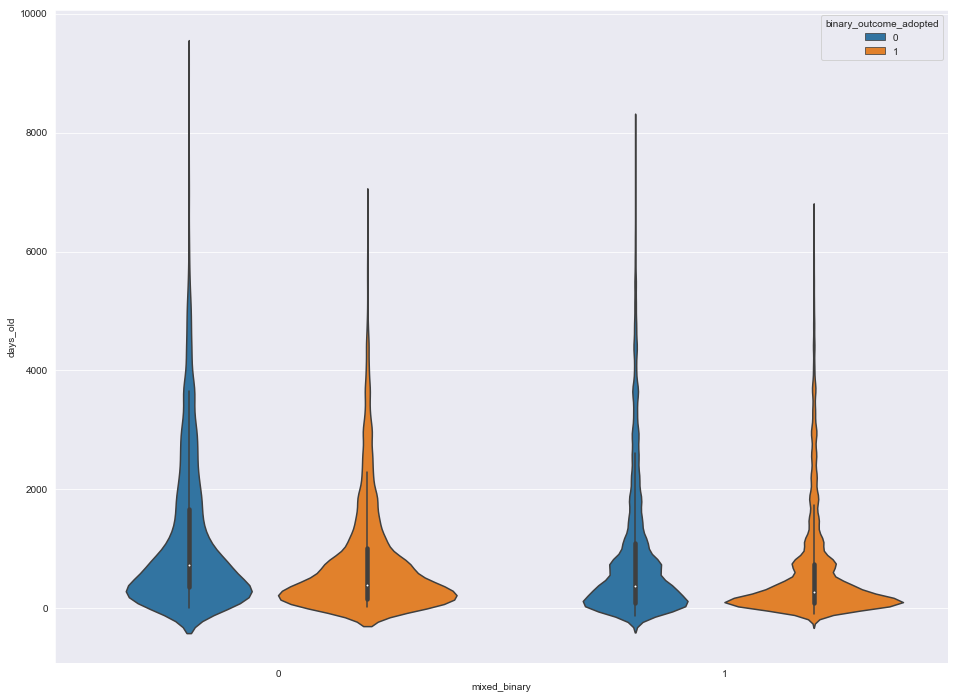

In [30]:
# We can run some visualizations on features against age.
fig, ax = plt.subplots(figsize=(16,12))
sns.violinplot(x='mixed_binary', y='days_old', hue='binary_outcome_adopted', data=df, ax=ax)

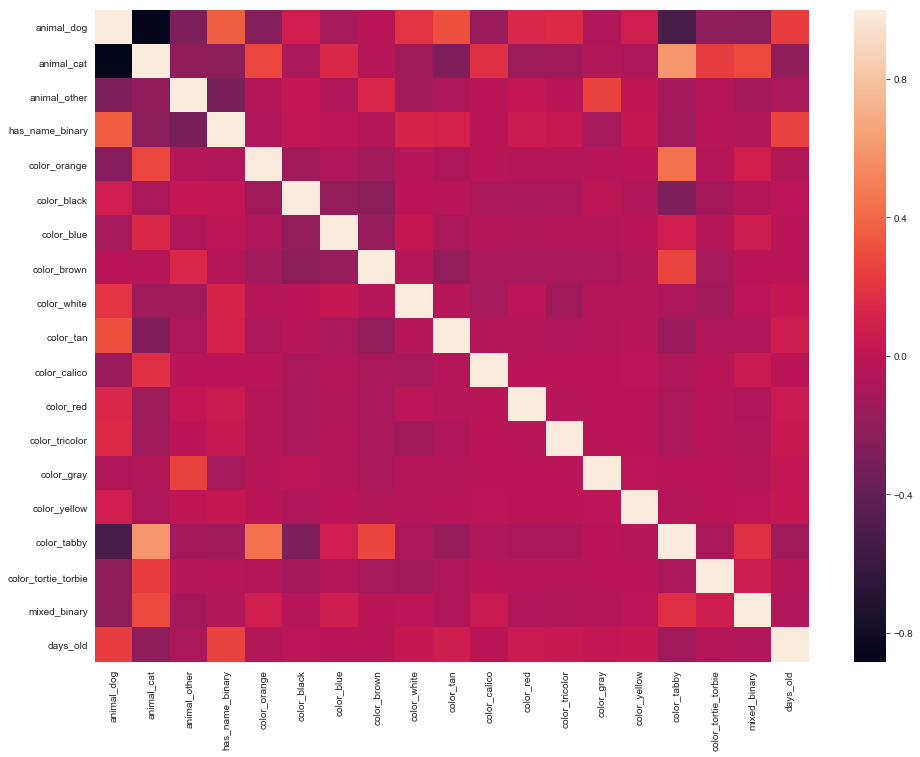

In [31]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df.iloc[:, 1:].corr())

### Notes: Dog and cat negative correlation

I want to see how the correlation heatmap responds to removing one of these strong negative correlations. Adios, puppers.

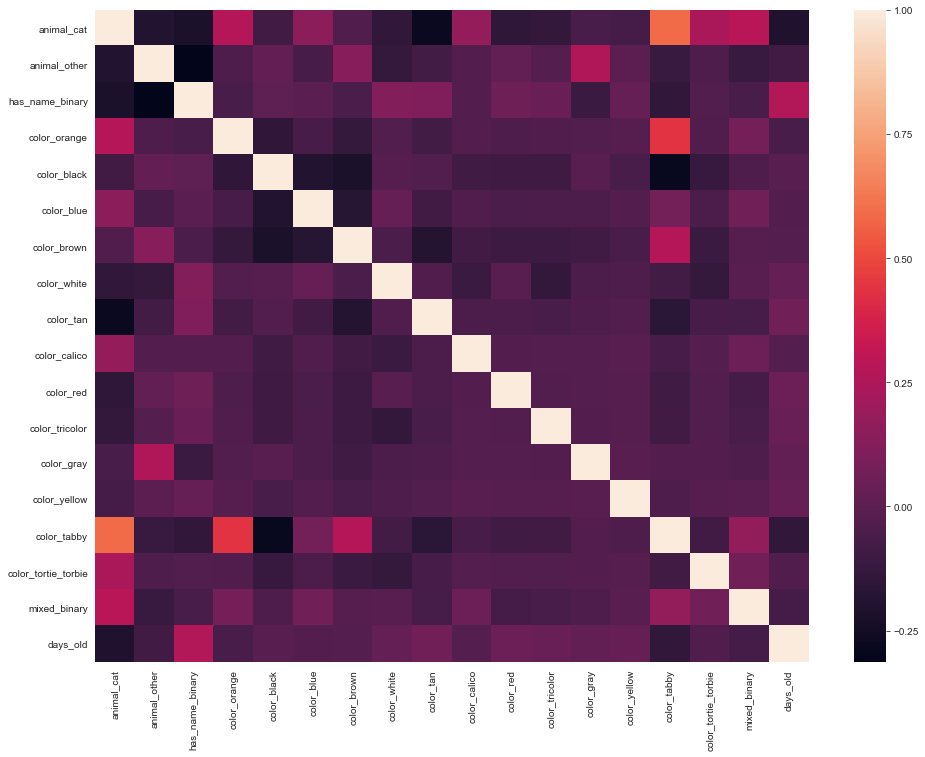

In [32]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df.iloc[:, 2:].corr())

### Notes: Cats, no dogs

This seems to bring in a nice palette of fairly neutral correlations.

# Classification models

### We have a wealth of classification tools to try

We are going to give several a shot.

- Naive Bayes
- Logistic Regression
- Ridge classification
- Lasso classification
- K-Nearest Neighbors classification
- Decision trees
- Random forest classification

Later on, with some idea of what is doing well, we will also try other ensemble methods, including voting.

In [33]:
# Import necessary libraries for NB, log_reg, ran_for, knn_c, ensembles, and trees
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Bernoulli prefers binary inputs!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X = df.iloc[:, 2:]
y = df.binary_outcome_adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

F:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [34]:
import re # We will need regular expression tricks clean up results and compare them
clf_bnb = BernoulliNB()
clf_gnb = GaussianNB()
clf_log = LogisticRegression(C=1e9) # We need a high alpha value (C) to suppress regularization
clf_rdg = RidgeClassifier(alpha=1000) # Using the same alpha value as LASSO - they are inverses
clf_las = LogisticRegression(penalty='l1', C=0.001) # This is using LASSO for classification
clf_knc = KNeighborsClassifier()
clf_tree = DecisionTreeClassifier() # Basic tree
# Ensemble methods below
clf_rnf = RandomForestClassifier()
clf_ada = AdaBoostClassifier()
clf_gbc = GradientBoostingClassifier()

clf_list = [clf_bnb, clf_gnb, clf_log, clf_rdg, clf_las, clf_knc, clf_tree, clf_rnf, clf_ada, clf_gbc]
pred_dict = {}
coef_dict = {}

for i, clf in enumerate(clf_list):
    name = re.split('\(', str(clf))[0] + '_clf' + str(i)
    print('Model used: {} \nScore: {}\n'.format(name, clf.fit(X_train, y_train).score(X_test, y_test)))
    pred_dict[name] = clf.fit(X_train, y_train).predict(X_test)
    try:
        coef_dict[name] = clf.fit(X_train, y_train).coef_
    except:
        pass

Model used: BernoulliNB_clf0 
Score: 0.6734819055407892

Model used: GaussianNB_clf1 
Score: 0.7187180535677775

Model used: LogisticRegression_clf2 
Score: 0.7481598855039869

Model used: RidgeClassifier_clf3 
Score: 0.7445818850950726

Model used: LogisticRegression_clf4 
Score: 0.7516867716213453

Model used: KNeighborsClassifier_clf5 
Score: 0.7509711715395625

Model used: DecisionTreeClassifier_clf6 
Score: 0.7404927417705991

Model used: RandomForestClassifier_clf7 
Score: 0.7543958290738091

Model used: AdaBoostClassifier_clf8 
Score: 0.7735636884072786

Model used: GradientBoostingClassifier_clf9 
Score: 0.789766918830505



# Models compared

In [35]:
print('Coefficients were not so useful, as only -- {} -- models return them to observe. \n\n Model scores:'
      .format(len(coef_dict)))
pred_dict

Coefficients were not so useful, as only -- 4 -- models return them to observe. 

 Model scores:


{'BernoulliNB_clf0': array([0, 0, 0, ..., 1, 1, 1], dtype=int32),
 'GaussianNB_clf1': array([1, 0, 0, ..., 1, 1, 1], dtype=int32),
 'LogisticRegression_clf2': array([0, 0, 0, ..., 1, 1, 1], dtype=int32),
 'RidgeClassifier_clf3': array([0, 0, 0, ..., 1, 1, 1], dtype=int32),
 'LogisticRegression_clf4': array([0, 0, 0, ..., 1, 1, 1], dtype=int32),
 'KNeighborsClassifier_clf5': array([1, 0, 0, ..., 1, 1, 1], dtype=int32),
 'DecisionTreeClassifier_clf6': array([0, 0, 0, ..., 1, 1, 0], dtype=int32),
 'RandomForestClassifier_clf7': array([0, 0, 0, ..., 1, 1, 0], dtype=int32),
 'AdaBoostClassifier_clf8': array([0, 0, 0, ..., 0, 1, 1], dtype=int32),
 'GradientBoostingClassifier_clf9': array([0, 0, 0, ..., 0, 1, 1], dtype=int32)}

### Confusion matrices compared:

Below, we have the outputs of confusion matrices for each model's performance.

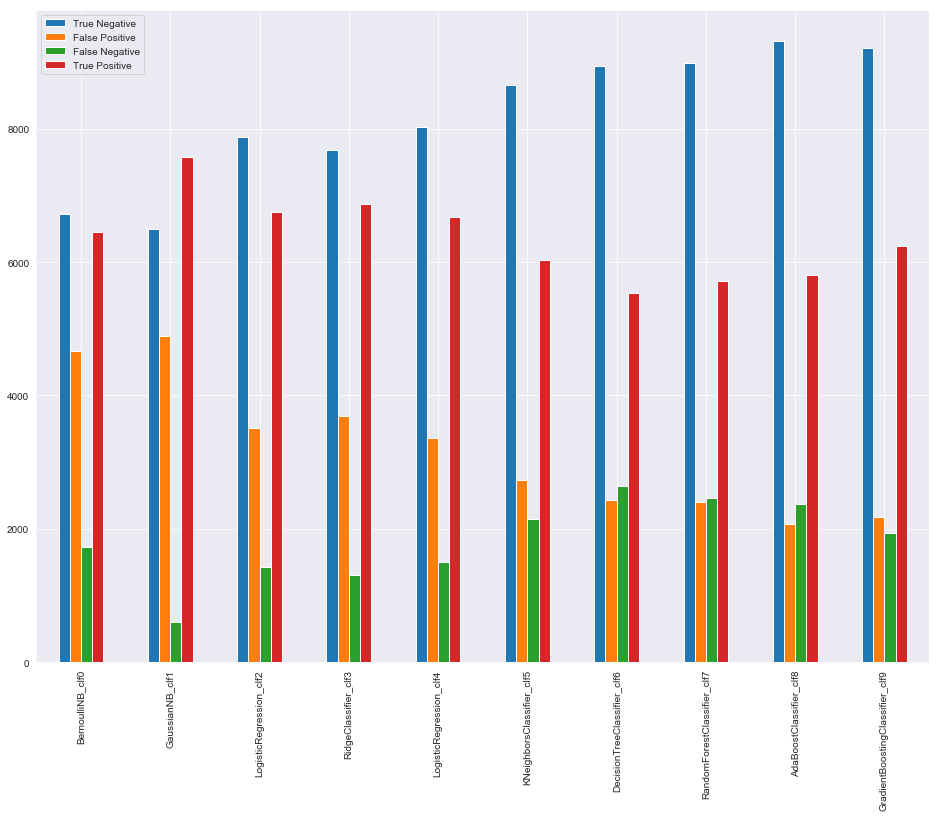

In [36]:
df_con = pd.DataFrame(np.array([(confusion_matrix(y_test, pred_dict[key]).ravel()) for key in pred_dict.keys()]),
             index=pred_dict.keys(), columns=['True Negative', 'False Positive', 'False Negative', 'True Positive'])

df_con.plot(kind='bar', figsize=(16,12))

### Notes: Confusion matrices comparisons

Ultimately, I think building an ensemble of well-performing models will make easy work of the predictions.

1. GaussianNB
    - This model is doing a *great* job of avoiding false negatives and identifying true positives.


2. DecisionTree
    - This model is doing surprisingly well as a single tree - particularly in the true negative category.


3. Lasso classification
    - It might be advisable to use Lasso for voting ensembles, as it is eliminating noise and offers a very different approach. Its numbers aren't too shabby either.
    
# Ensemble goal: To build a better ensemble than the best off-the-shelf

GradientBoosting performed quite well out of the box. Since this is an ensemble approach, let's combine a few of our own from above to beat it.

### GridSearch to optimize models

We will begin with optimizing the models that are doing well already - as mentioned above: GaussianNB, DecisionTree, and LASSO.

In [52]:
clf_gnb = GaussianNB()
clf_tree = DecisionTreeClassifier()
clf_las = LogisticRegression()

gnb_params = {'var_smoothing': [1e-10, 1e-9, 1e-8]} # This only works with specified priors
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, None]}
las_params = {'penalty': ['l1'], 'C': [1, 1e-1, 1e-2, 1e-3], 'solver': ['liblinear', 'saga']}

#GridSearchCV(clf_gnb, gnb_params, cv=5).fit(X_train, y_train)
grid_tree = GridSearchCV(clf_tree, tree_params, cv=5).fit(X_train, y_train)
grid_las = GridSearchCV(clf_las, las_params, cv=5).fit(X_train, y_train)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [53]:
grid_tree.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [ ]:
grid